# TF2 RNN


## Recurrent Neural Network, 순환 신경망
* 과거의 행위가 다음 판단에 영향을 미치는 경우
    * 순서가 있는 데이터
    * 한번의 입력 만으로 출력 예측 불가
        * 처음 보는 아이구나! 안녕! (안녕:만남)
        * 그 동안 즐거웠어... 안녕! (안녕:작별)
    * 이번의 입력과 그 이전의 입력을 모두 기억해야 출력 예측 가능
* 구조적 특징
    * 이전 상태 유지
    ```python
    state = 0
    for input in inputs:
        outout, state = rnn_cell(input, state)
    ```
![image.png](https://i.imgur.com/Ot9qXuc.png)

*  RNN 유형
![https://i.imgur.com/MAesSJV.png](https://static.packt-cdn.com/products/9781789536089/graphics/b2e068f5-08f8-4e4a-b56c-e29675ab0eb5.png)
* RNN 개선 네트웤
    * LSTM(Long Short Term Memory)
    * GRU

## Vanilla RNN
* RNN Layer 구조
    * 상태 유지를 위한 vector : $h_t$
    * $h_t = f(x_t, h_{t-1})$
        * 입력 : $x_t, h_{t-1}$
            * $x_t$ : 이번 단계의 입력 변수
            * $h_{t-1}$ : 이전 단계의 hidden state
        * 출력 : $h_t$ : 현재 단계의 hidden state
        * $h_t = tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$
            * $tanh$ : $sigmoid$ 보다 미분 값이 크다
* Linear NN(Dense) Layer
    * $ y_t = W_{hy}h_t + b_y $ 
    * 일반적인 신경망
        
![image.png](https://i.imgur.com/Q1xfRVJ.png)
* 학습할 변수들, 5개
    * $W_{hx}$, $W_{hh}$, $b_h$
    * $W_{hy}$, $b_y$

### Vanilla RNN Graph
![image.png](https://i.imgur.com/Szpv2aU.png)

### RNN 실습, Many to One
* RNN 구조를 직접 구현해서 다음 숫자 예측하는 실습
    * 입력 : 0.1씩 증가하는 4개의 연속 숫자
    * 출력 : 입력의 마지막 숫자 보다 0.1 큰 수
        * 0.0, 0.1, 0.2, 0.3 = 0.4
        * 0.1, 0.2, 0.3, 0.4 = 0.5
        * 0.9, 1.0, 1.1, 1.2 = 1.3
    
    

#### 입출력 데이타 준비

In [44]:
import tensorflow as tf
import numpy as np

step_size = 4
batch_size = 5

x = [ [[i/10] for i in range(j, j+step_size)] for j in range(batch_size)]
y = [[ (i+step_size) /10] for i in range(batch_size)]
display("x", x, "y",y)

'x'

[[[0.0], [0.1], [0.2], [0.3]],
 [[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]]]

'y'

[[0.4], [0.5], [0.6], [0.7], [0.8]]

#### RNN 연산을 위한 함수
* `tf.scan(fn, elements)`
    * 모든 elemes를 순회하면서 fn에 전달
    * 이전 fn의 반환 값과 elemens의 다음 항목을 fn에 전달
    * 모든 fn의 반환 값을 리스트로 반환, elements이 길이와 동일

In [45]:
# tf.scan() 사용 설명을 위한 예시
def fn(p, n):
    print(p.shape, n.shape)
    return p + n

elements = np.arange(10).reshape(-1,2,1)
print(elements, elements.shape)

ret = tf.scan(fn, elements)
print(ret)

[[[0]
  [1]]

 [[2]
  [3]]

 [[4]
  [5]]

 [[6]
  [7]]

 [[8]
  [9]]] (5, 2, 1)
(2, 1) (2, 1)
(2, 1) (2, 1)
(2, 1) (2, 1)
(2, 1) (2, 1)
tf.Tensor(
[[[ 0]
  [ 1]]

 [[ 2]
  [ 4]]

 [[ 6]
  [ 9]]

 [[12]
  [16]]

 [[20]
  [25]]], shape=(5, 2, 1), dtype=int32)


#### RNN Layer hidden state 변수와 연산 함수 정의

In [49]:
element_size = 1
hidden_size = 10
initializer =  tf.keras.initializers.GlorotUniform() #xavier
Wx = tf.Variable(initializer([element_size, hidden_size]))
Wh = tf.Variable(initializer([hidden_size, hidden_size]))
bh = tf.Variable(initializer([hidden_size]))

def rnn_step(prev_h, x):
    curr_h = tf.tanh(
                    tf.matmul(prev_h, Wh) + 
                    tf.matmul(x, Wx) +
                    bh)
    return curr_h # shape: (batch_size,4)

#### Linear Layer 연산을 위한 변수와 함수 정의

In [50]:
initializer =  tf.keras.initializers.GlorotUniform() #xavier

Wy = tf.Variable(initializer([hidden_size, element_size]))
by = tf.Variable(initializer([element_size]))

def linear_layer(hidden_states):
    return tf.matmul(hidden_states, Wy) + by

#### 신경망 학습

In [51]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mse = tf.keras.losses.MeanSquaredError()
n_epoch = 1000
all_outputs, output = None, None
for epoch in range(n_epoch):
    with tf.GradientTape() as tape:
        X_ = tf.transpose(x, perm=[1, 0, 2]) # (4,10,1)
        init_hidden = tf.zeros([batch_size, hidden_size]) # (10,4)
        hidden_states = tf.scan(rnn_step, X_, initializer=init_hidden)
        all_outputs = tf.matmul(hidden_states, Wy) + by
        output = all_outputs[-1]
        cost = tf.reduce_mean( tf.square(output - y))
    grads = tape.gradient(cost, [Wy, by, Wx, Wh,  bh])
    optimizer.apply_gradients(zip(grads, [Wy, by, Wx, Wh,  bh]))
    if (epoch+1) % 50 == 0:
        print(f"epoch:{epoch}, cost:{cost}")
print(f'predict:{tf.squeeze(output)}')

epoch:49, cost:0.21758830547332764
epoch:99, cost:0.068544901907444
epoch:149, cost:0.04512929916381836
epoch:199, cost:0.02724112942814827
epoch:249, cost:0.013455492444336414
epoch:299, cost:0.004864203743636608
epoch:349, cost:0.001207142835482955
epoch:399, cost:0.00021769237355329096
epoch:449, cost:4.3507327063707635e-05
epoch:499, cost:2.1995603674440645e-05
epoch:549, cost:1.9816836356767453e-05
epoch:599, cost:1.941706614161376e-05
epoch:649, cost:1.9139284631819464e-05
epoch:699, cost:1.886774589365814e-05
epoch:749, cost:1.8597653252072632e-05
epoch:799, cost:1.8329965314478613e-05
epoch:849, cost:1.8065300537273288e-05
epoch:899, cost:1.7805597963160835e-05
epoch:949, cost:1.7551530618220568e-05
epoch:999, cost:1.7303242202615365e-05
predict:[0.40491617 0.49364746 0.5982585  0.70428205 0.7992102 ]


### TF RNN API
* `cell = tf.keras.layers..rnn_cell.SimpleRNNCell(units=hidden_size)`
    * RNN 구현을 위해 필요한 변수 선언 및 구조 제공
    * `hidden_size` : output, state size
* `rnn = tf.keras.layers.RNN(cell,return_sequences=True, return_state=True)`
* `outputs, states = rnn(X)`
    * rnn_cell을 전달 받아 반복(tf.scan()) 연산해서 output과 state 계산
    * rnn.trainable_variables : 학습할 변수 얻기
* `rnn = tf.keras.layers..rnn_cell.SimpleRNNCell(units=hidden_size, return_sequences=True, return_state=True)`
    * SimpleRNNCell + RNN
    * Cell과 RNN 역할을 동시에 수행

#### TF RNN API 써보기

In [16]:
import tensorflow as tf
import numpy as np

x_data = np.array([[[1,2,3,4],
                    [5,6,7,8]]], dtype=np.float32) #(1,2,4) : (batch, time_step, element_size)
print(x_data.shape)

h_size = 3   # output_size
cell = tf.keras.layers.SimpleRNNCell(h_size)
print(cell.output_size, cell.state_size)

rnn = tf.keras.layers.RNN(cell, return_sequences=True, return_state=True)
#rnn = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, return_state=True)
outputs, return_state = rnn(x_data)
print(outputs, return_state)
print(rnn.trainable_variables)


(1, 2, 4)
3 3
tf.Tensor(
[[[ 0.99952966 -0.9585948  -0.9989488 ]
  [ 0.9999997  -0.9999876  -0.99999976]]], shape=(1, 2, 3), dtype=float32) tf.Tensor([[ 0.9999997  -0.9999876  -0.99999976]], shape=(1, 3), dtype=float32)
[<tf.Variable 'rnn_2/kernel:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.11117774,  0.16613972,  0.6421424 ],
       [ 0.0297879 , -0.3033737 , -0.4533883 ],
       [ 0.5253105 , -0.84494674, -0.44412813],
       [ 0.6632879 ,  0.26178992, -0.5445496 ]], dtype=float32)>, <tf.Variable 'rnn_2/recurrent_kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.9255129 , -0.36553076,  0.09906177],
       [ 0.14769028, -0.10749933,  0.9831742 ],
       [-0.34873134,  0.9245708 ,  0.1534773 ]], dtype=float32)>, <tf.Variable 'rnn_2/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


#### TF RNN API를 이용한 다음 수 예측 실습

In [24]:
initializer =  tf.initializers.GlorotUniform() #xavier
Wy = tf.Variable(initializer([hidden_size, element_size]))
by = tf.Variable(initializer([element_size]))

learning_rate = 0.1
#cell = tf.keras.layers.SimpleRNNCell(hidden_size)
#rnn = tf.keras.layers.RNN(cell, return_sequences=False, return_state=True)

# return_sequences=Flase : 모든 seqence의 상태 말고 마지막 sequence만 반환
rnn = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=False, return_state=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
n_epoch = 1000
for epoch in range(n_epoch):
    with tf.GradientTape() as tape:
        outputs, states = rnn(tf.constant(x))
        output = tf.matmul(outputs, Wy) + by
        variables = rnn.trainable_variables + [Wy, by]
        #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=all_outputs, labels=y_enc))
        cost = tf.reduce_mean( tf.square(output - y))
    grads = tape.gradient(cost, variables)
    optimizer.apply_gradients(zip(grads, variables))
    if (epoch+1) % 50 == 0:
        print(f"epoch:{epoch}, cost:{cost}")
print(f'predict:{tf.squeeze(output)}')

epoch:49, cost:0.0004836990556214005
epoch:99, cost:7.325842489080969e-06
epoch:149, cost:3.182115733579849e-06
epoch:199, cost:2.907152065745322e-06
epoch:249, cost:2.770936816887115e-06
epoch:299, cost:2.662070528458571e-06
epoch:349, cost:2.556670551712159e-06
epoch:399, cost:2.451454747642856e-06
epoch:449, cost:2.3471216081816237e-06
epoch:499, cost:2.244477627755259e-06
epoch:549, cost:2.1444154754135525e-06
epoch:599, cost:0.008287915959954262
epoch:649, cost:1.4186024600348901e-05
epoch:699, cost:3.37490064339363e-06
epoch:749, cost:3.0825099202047568e-06
epoch:799, cost:2.8889430723211262e-06
epoch:849, cost:2.710974285946577e-06
epoch:899, cost:2.5462366011197446e-06
epoch:949, cost:2.394181819909136e-06
epoch:999, cost:2.2533392893819837e-06
predict:[0.40117896 0.49785855 0.5999218  0.7020624  0.7989845 ]


#### TF Keras Model을 이용한 다음 수 예측 실습

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=[step_size, element_size]),
    tf.keras.layers.Dense(element_size)
])
model.summary()
model.compile(optimizer='adam', loss='mse')

model.fit(x, y, epochs=1000, verbose=0)
pred = model.predict(x)
print(f'prediction: {tf.squeeze(pred)}')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_18 (SimpleRNN)    (None, 10)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
prediction: [0.3755046  0.5133306  0.62723434 0.71219724 0.7685203 ]


### Vanila RNN 실습2, Many to Many
* RNN 구조를 직접 구현해서 다음 숫자 예측하는 실습
    * 입력 : 0.1씩 증가하는 4개의 연속 숫자
    * 출력 : 입력의 두번째 숫자 부터 마지막의 다음 숫자
        * 0.0, 0.1, 0.2, 0.3 = 0.1, 0.2, 0.3, 0.4
        * 0.1, 0.2, 0.3, 0.4 = 0.2, 0.3, 0.4, 0.5
        * 0.9, 1.0, 1.1, 1.2 = 1.0, 1.1, 1.2, 1.3

#### 입출력 데이타 준비

In [83]:
import tensorflow as tf
import numpy as np

step_size = 4
batch_size = 5

x = [ [[i/10] for i in range(j, j+step_size)] for j in range(batch_size)]
y = [ [[i/10] for i in range(j+1, j+step_size+1)] for j in range(batch_size)]
display("x", x, "y",y)

'x'

[[[0.0], [0.1], [0.2], [0.3]],
 [[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]]]

'y'

[[[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]],
 [[0.5], [0.6], [0.7], [0.8]]]

#### TF Low API를 이용한 실습

In [85]:
element_size = 1
hidden_size = 10
initializer =  tf.keras.initializers.GlorotUniform() #xavier
Wx = tf.Variable(initializer([element_size, hidden_size]))
Wh = tf.Variable(initializer([hidden_size, hidden_size]))
bh = tf.Variable(initializer([hidden_size]))

def rnn_step(prev_h, x):
    curr_h = tf.tanh(
                    tf.matmul(prev_h, Wh) + 
                    tf.matmul(x, Wx) +
                    bh)
    return curr_h # shape: (batch_size,4)


initializer =  tf.keras.initializers.GlorotUniform() #xavier

Wy = tf.Variable(initializer([hidden_size, element_size]))
by = tf.Variable(initializer([element_size]))

def linear_layer(hidden_states):
    return tf.matmul(hidden_states, Wy) + by

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
mse = tf.keras.losses.MeanSquaredError()
n_epoch = 1000
all_outputs, output = None, None
for epoch in range(n_epoch):
    with tf.GradientTape() as tape:
        X_ = tf.transpose(x, perm=[1, 0, 2]) # (4,10,1)
        init_hidden = tf.zeros([batch_size, hidden_size]) # (10,4)
        hidden_states = tf.scan(rnn_step, X_, initializer=init_hidden)
        all_outputs = tf.matmul(hidden_states, Wy) + by
        outputs = tf.transpose(all_outputs, perm=[1, 0, 2])
        cost = tf.reduce_mean( tf.square(outputs - y))
    grads = tape.gradient(cost, [Wy, by, Wx, Wh,  bh])
    optimizer.apply_gradients(zip(grads, [Wy, by, Wx, Wh,  bh]))
    if (epoch+1) % 50 == 0:
        print(f"epoch:{epoch}, cost:{cost}")
print(f'predict:{tf.squeeze(outputs)}')

epoch:49, cost:0.04279259592294693
epoch:99, cost:0.021712452173233032
epoch:149, cost:0.011313172057271004
epoch:199, cost:0.007589862681925297
epoch:249, cost:0.005611711647361517
epoch:299, cost:0.004251373000442982
epoch:349, cost:0.0032375119626522064
epoch:399, cost:0.002461089286953211
epoch:449, cost:0.0018616083543747663
epoch:499, cost:0.001397828571498394
epoch:549, cost:0.001039541675709188
epoch:599, cost:0.0007640495896339417
epoch:649, cost:0.0005539843114092946
epoch:699, cost:0.0003957711742259562
epoch:749, cost:0.0002785435935948044
epoch:799, cost:0.00019340419385116547
epoch:849, cost:0.00013298090198077261
epoch:899, cost:9.11684546736069e-05
epoch:949, cost:6.298776133917272e-05
epoch:999, cost:4.448329855222255e-05
predict:[[0.11455545 0.19096842 0.29799488 0.40783828]
 [0.2063249  0.30026263 0.40277338 0.49637073]
 [0.29980567 0.40484583 0.5033149  0.59178764]
 [0.39355886 0.50453526 0.60052073 0.6957625 ]
 [0.48616377 0.5992918  0.6951349  0.8084848 ]]


#### TF Keras를 이용한 실습

In [86]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=[step_size, element_size], return_sequences=True),
    tf.keras.layers.Dense(element_size)
])
model.summary()
model.compile(optimizer='adam', loss='mse')

model.fit(x, y, epochs=1000, verbose=0)
pred = model.predict(x)
print(f'prediction: {tf.squeeze(pred)}')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 4, 10)             120       
_________________________________________________________________
dense_7 (Dense)              (None, 4, 1)              11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
prediction: [[0.2834577  0.21673763 0.27802214 0.38358343]
 [0.2944024  0.31542468 0.39945063 0.5002965 ]
 [0.30445662 0.4112241  0.51065373 0.60875326]
 [0.3132205  0.5031215  0.60719633 0.7082859 ]
 [0.32035115 0.5903807  0.68736416 0.7984788 ]]


### MNIST 숫자 손글씨 인식
* many to one
* 28 * 28 숫자 이미지 : 시퀀스로서의 이미지
* 28 step(sequence)
* 각 스텝당 28개의 입력
![image.png](https://i.imgur.com/1dwjGgP.png)

#### SimpleRNN으로 MNIST 실습

In [89]:
import tensorflow as tf

element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128

# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    # Train set
    train_x = train_x.astype('float32') / 255.
    # Test set
    test_x = test_x.astype('float32') / 255.
    return (train_x, train_y), (test_x, test_y)

# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN((hidden_layer_size), input_shape=(time_steps, element_size)))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_x, train_y,
                    epochs=20, batch_size=batch_size,
                    validation_data=(valid_x, valid_y),
                    verbose=0)

results = model.evaluate(test_x, test_y,  verbose=1)
print(f"Test loss:{results[0]}, accuracy:{results[1]}")

10000/10000 [==============================] - 1s 136us/sample - loss: 0.0970 - accuracy: 0.9730
Test loss:0.09703949805349112, accuracy:0.9729999899864197


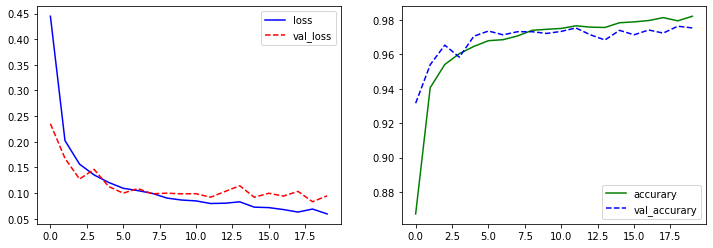

In [90]:
import matplotlib.pyplot as plt

def drawPlot(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'b', label="loss")
    plt.plot(history.history['val_loss'], 'r--', label="val_loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], 'g', label="accurary")
    plt.plot(history.history['val_accuracy'], 'b--', label="val_accurary")
    plt.legend()
    plt.show()
drawPlot(history)

## LSTM
* Long Short-Term Memory Unit
* Sepp Hochreiter(셉 호흐라이터), Jurgen Schmidhuber(유르겐 슈미트후버) 1997년 제안
    * RNN의 장기의존성(Longterm Dependency) 문제 보완
        * 장기의존성 : 과거 시점이 현재와 너무 멀어지면 문제 해결 불가
* LSTM 구조
    * 입력 : $x_t, h_{t-1}, c_{t-1}$
    * 출력 : $h_t, c_t$
    * $c_t$ cell state
        * RNN에 추가된 상태 벡터
        * 이전 정보를 다음 단계로 전달
        * 3가지 게이트에 의해 전달 여부 결정
    * $\sigma (sigmoid)$ 활성화 함수: 0 ~ 1 범위 출력, 게이트 역할
    * $f_t$ Forget Gate : 기존 Cell State에서 어떠한 정보를 지울 지 결정
    * $i_t$ Input Gate : Cell State에 저장할 새로운 정보를 결정
    * $o_t$ Output Gate : Cell State 값을 다음 상태로 출력할 지 결정
    
![](https://i.imgur.com/t1ICToX.jpg)
<!-- ![image.png](https://i.imgur.com/POpVFUa.png) -->

#### LSTM TF API
* `tf.keras.layers.LSTMCell()`
* `tf.keras.layers.LSTM()`

#### LSTM으로 MNIST 실습

In [91]:
import tensorflow as tf

element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128

# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    # Train set
    train_x = train_x.astype('float32') / 255.
    # Test set
    test_x = test_x.astype('float32') / 255.
    return (train_x, train_y), (test_x, test_y)

# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM((hidden_layer_size), input_shape=(time_steps, element_size)))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_x, train_y,
                    epochs=20, batch_size=batch_size,
                    validation_data=(valid_x, valid_y),
                    verbose=0)

results = model.evaluate(test_x, test_y,  verbose=1)
print(f"Test loss:{results[0]}, accuracy:{results[1]}")

10000/10000 [==============================] - 1s 93us/sample - loss: 0.0435 - accuracy: 0.9875
Test loss:0.043522600721823984, accuracy:0.987500011920929


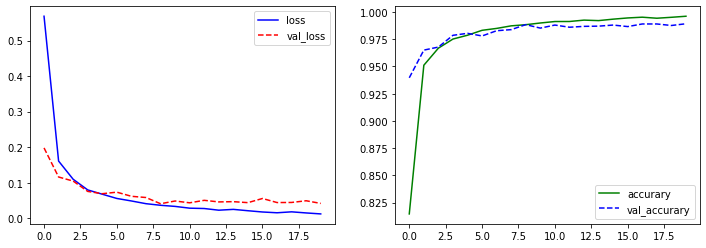

In [92]:
drawPlot(history)

## GRU
* Gated Recurrent Units
* 2014 뉴욕대 조경현 교수 제안 
    * LSTM와 비슷한 효과, 더 단순한 구조
    * 계산 비용 감소
    * 문제에 따라 더 좋은 성능
    
* GRU 구조
    * $c_t$ cell state 제거, $h_t$로 통합
    * 게이트 갯수 감소
        * $r_t$ Reset 게이트 : 이전 스텝의 정보를 얼마나 남길지 결정
        * $z_t$ Update 게이트 : LSTM의 Input,Forget 게이트 통합
![image.png](https://i.imgur.com/c2YyJz9.png)

#### GRU TF API
* `tf.keras.layers.GRUCell()`
* `tf.keras.layers.GRU()`

#### GRU로 MNIST 실습

In [93]:
import tensorflow as tf

element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128

# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    # Train set
    train_x = train_x.astype('float32') / 255.
    # Test set
    test_x = test_x.astype('float32') / 255.
    return (train_x, train_y), (test_x, test_y)

# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU((hidden_layer_size), input_shape=(time_steps, element_size)))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_x, train_y,
                    epochs=20, batch_size=batch_size,
                    validation_data=(valid_x, valid_y),
                    verbose=0)

results = model.evaluate(test_x, test_y,  verbose=1)
print(f"Test loss:{results[0]}, accuracy:{results[1]}")

10000/10000 [==============================] - 1s 83us/sample - loss: 0.0481 - accuracy: 0.9876
Test loss:0.0481272860016732, accuracy:0.9876000285148621


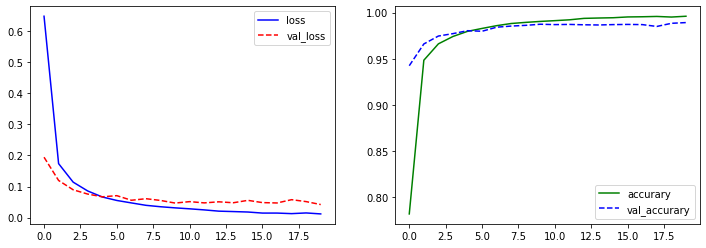

In [94]:
drawPlot(history)

## 텍스트 데이터 다루기
* 텍스트 : 가장 흔한 시퀀스 데이타
* 텍스트 데이타의 벡터화(Vectorizing Text)
    * Nueral Net 입력은 숫자만 가능
    * Text Tokenization : 처리 가능한 작은 단위로 나누는 것
        * Word Tokenizing : 단어 단위로 나누기
            * "hi hello" : \["hi", "hello"\] 
        * Char Tokenizing : 문자 단위로 나누기
            * "hi hello" : \["h","i", "h", "e", "l", "l", "o"\]
        * 그 밖의 Tokenization
            * 문장, 형태소, 자소, n-gram
    * Indexing
        * 사전 생성 : 고유 토큰에게 고유한 번호 부여
            * 예: {'h':0, 'i': 1, 'e':2, 'l':3, 'o':4}
        * 고유 인덱스로 변환
            * 예: "hihello" : \[0,1,0,2,3,3,4\]
    * One-hot Encoding : 사전의 크기와 동일한 크기의 벡터, 해당 요소번째 만 1을 갖고 나머지는 0을 갖는다.
        * 예)
            * 'h' : \[1,0,0,0,0\]
            * 'i' : \[0,1,0,0,0\]
            * 'e' : \[0,0,1,0,0\]

### Text 데이타 실습, One-hot Encoding
* 다음 글자 예측하는 실습
    * 입력 : "hihell"
    * 출력 : "ihello"
    * many to many 유형
![image.png](https://i.imgur.com/F8toAhT.png)

#### 입출력 데이타 준비

In [96]:
import tensorflow as tf
import numpy as np

sentence = "hihello"

voca = set(sentence) #unique charters
char2idx = {c:i for i,c in enumerate(voca)}
idx2char = {i:c for i, c in enumerate(voca)}
print(f'sentence:{sentence}')
print(f'char2idx:{char2idx}, idx2char:{idx2char}')

x = sentence[:-1] #"hihell"
y = sentence[1:] #"ihello"
print(f'x:{x}, y:{y}')

n_class = len(voca)  #example size
n_time_steps = len(x) #input sequence
hidden_size = n_class #output size

''' convert char to integer '''
x_idx = [char2idx[c] for c in x]
y_idx = [char2idx[c] for c in y]
print(f"x_idx:{x_idx}, y_idx:{y_idx}")

''' one-hot encoding'''
x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )
print("y_enc:", y_enc, y_enc.shape)

sentence:hihello
char2idx:{'e': 0, 'l': 1, 'i': 2, 'o': 3, 'h': 4}, idx2char:{0: 'e', 1: 'l', 2: 'i', 3: 'o', 4: 'h'}
x:hihell, y:ihello
x_idx:[4, 2, 4, 0, 1, 1], y_idx:[2, 4, 0, 1, 1, 3]
x_enc: [[[0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]]] (1, 6, 5)


#### LSTM을 이용한 모델 학습

In [100]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(hidden_size, input_shape=(n_time_steps, n_class), return_sequences=True))
model.add(tf.keras.layers.Dense(hidden_size))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

n_epochs = 1000
history = model.fit(x_enc, np.reshape(y_idx, (1,6,1)), epochs=n_epochs, verbose=0)

preds = model.predict(x_enc)
print(preds, np.squeeze(np.argmax(preds, axis=2)))
print([idx2char[i] for i in np.squeeze(np.argmax(preds, axis=2))])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6, 5)              220       
_________________________________________________________________
dense_15 (Dense)             (None, 6, 5)              30        
_________________________________________________________________
activation_9 (Activation)    (None, 6, 5)              0         
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________
[[[5.7636272e-02 3.2721840e-02 8.1942415e-01 6.9915815e-03 8.3226211e-02]
  [1.7295246e-01 1.0505311e-02 6.7424826e-02 2.5534625e-03 7.4656397e-01]
  [7.7144426e-01 4.3208193e-02 2.9042009e-02 1.2520365e-03 1.5505353e-01]
  [4.9345892e-02 9.1402274e-01 9.5988065e-03 2.2867098e-02 4.1654333e-03]
  [9.9146655e-03 9.0968257e-01 3.2896472e-03 7.6471224e-02 6.4188422e-04]
  [1.2772365e-0

### TF Tokenization API
* TF keras API
    * `tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words, filters, lower, split, char_level, oov_token, document_count)`
        * `num_words` : 보관할 단어 최대 갯수
        * `filters` : 토큰에서 제외한 규칙, 정규 표현식
        * `tokenizer.fit_on_texts(text)`
        * `tokenizer.fit_on_sequence(seqence)`
        * `tokenizer.texts_to_sequences(text)`
        * `tokenizer.texts_to_matrix(texts, mode='binary')`
    * `tf.keras.preprocessing.sequence.pad_sequences`
    * `tf.keras.preprocessing.sequence.skipgrams`
    * `tf.keras.layers.Embedding`
    

In [24]:
import tensorflow as tf

samples = ['The cat sat on the mat']

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(samples)
display(tokenizer.get_config())
print(tokenizer.word_index)

word_sequence = tokenizer.texts_to_sequences(samples)
print(word_sequence)
word_one_hot = tf.keras.utils.to_categorical(word_sequence)
print(word_one_hot)

char_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(samples)
display(char_tokenizer.get_config())
char_sequence = char_tokenizer.texts_to_sequences(samples)
print(char_sequence)
char_one_hot = tf.keras.utils.to_categorical(char_sequence)
print(char_one_hot)

print(char_tokenizer.index_word[4])

{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 1,
 'word_counts': '{"the": 2, "cat": 1, "sat": 1, "on": 1, "mat": 1}',
 'word_docs': '{"sat": 1, "mat": 1, "cat": 1, "on": 1, "the": 1}',
 'index_docs': '{"3": 1, "5": 1, "2": 1, "4": 1, "1": 1}',
 'index_word': '{"1": "the", "2": "cat", "3": "sat", "4": "on", "5": "mat"}',
 'word_index': '{"the": 1, "cat": 2, "sat": 3, "on": 4, "mat": 5}'}

{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5}
[[1, 2, 3, 4, 1, 5]]
[[[0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1.]]]


{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': None,
 'document_count': 1,
 'word_counts': '{"t": 5, "h": 2, "e": 2, " ": 5, "c": 1, "a": 3, "s": 1, "o": 1, "n": 1, "m": 1}',
 'word_docs': '{" ": 1, "c": 1, "t": 1, "e": 1, "a": 1, "o": 1, "n": 1, "m": 1, "h": 1, "s": 1}',
 'index_docs': '{"2": 1, "6": 1, "1": 1, "5": 1, "3": 1, "8": 1, "9": 1, "10": 1, "4": 1, "7": 1}',
 'index_word': '{"1": "t", "2": " ", "3": "a", "4": "h", "5": "e", "6": "c", "7": "s", "8": "o", "9": "n", "10": "m"}',
 'word_index': '{"t": 1, " ": 2, "a": 3, "h": 4, "e": 5, "c": 6, "s": 7, "o": 8, "n": 9, "m": 10}'}

[[1, 4, 5, 2, 6, 3, 1, 2, 7, 3, 1, 2, 8, 9, 2, 1, 4, 5, 2, 10, 3, 1]]
[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
h


### 단어 자동 완성 실습
* 영문자 4개로 구성된 단어를 학습
* 3글자 입력, 1글자 추천

#### 데이타 준비

In [128]:
import tensorflow as tf
import numpy as np

seq_data = ['word', 'wood', 'deep', 'dive', 'cold', 'love', 'cool', 'load', 'kiss', 'kind']

tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(seq_data)
display(tokenizer.get_config())

sequence = tokenizer.texts_to_sequences(seq_data)
print(sequence)

x = np.array(sequence)[:, :-1]
y = np.array(sequence)[:, -1]

x_enc = tf.keras.utils.to_categorical(x)
y_enc = tf.keras.utils.to_categorical(y)

{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': None,
 'document_count': 10,
 'word_counts': '{"w": 2, "o": 8, "r": 1, "d": 7, "e": 4, "p": 1, "i": 3, "v": 2, "c": 2, "l": 4, "a": 1, "k": 2, "s": 2, "n": 1}',
 'word_docs': '{"o": 6, "d": 7, "w": 2, "r": 1, "p": 1, "e": 3, "i": 3, "v": 2, "c": 2, "l": 4, "a": 1, "k": 2, "s": 1, "n": 1}',
 'index_docs': '{"1": 6, "2": 7, "6": 2, "11": 1, "12": 1, "3": 3, "5": 3, "7": 2, "8": 2, "4": 4, "13": 1, "9": 2, "10": 1, "14": 1}',
 'index_word': '{"1": "o", "2": "d", "3": "e", "4": "l", "5": "i", "6": "w", "7": "v", "8": "c", "9": "k", "10": "s", "11": "r", "12": "p", "13": "a", "14": "n"}',
 'word_index': '{"o": 1, "d": 2, "e": 3, "l": 4, "i": 5, "w": 6, "v": 7, "c": 8, "k": 9, "s": 10, "r": 11, "p": 12, "a": 13, "n": 14}'}

[[6, 1, 11, 2], [6, 1, 1, 2], [2, 3, 3, 12], [2, 5, 7, 3], [8, 1, 4, 2], [4, 1, 7, 3], [8, 1, 1, 4], [4, 1, 13, 2], [9, 5, 10, 10], [9, 5, 14, 2]]


#### 모델 구성 및 훈련

In [133]:
hidden_size = 128
n_time_steps = 3
n_class = max(tokenizer.index_docs) +1
print(tokenizer.word_counts)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(hidden_size, input_shape=(n_time_steps, n_class), return_sequences=False))
model.add(tf.keras.layers.Dense(hidden_size))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

n_epochs = 1000
history = model.fit(x_enc, y, epochs=n_epochs, verbose=0)

preds = model.predict(x_enc)
print(preds, np.argmax(preds, axis=1))
print(f'prediction: {[tokenizer.index_word[i] for i in np.argmax(preds, axis=1)]}')
print(f'inputs : {tokenizer.sequences_to_texts(x)}')

OrderedDict([('w', 2), ('o', 8), ('r', 1), ('d', 7), ('e', 4), ('p', 1), ('i', 3), ('v', 2), ('c', 2), ('l', 4), ('a', 1), ('k', 2), ('s', 2), ('n', 1)])
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               73728     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_14 (Activation)   (None, 128)               0         
Total params: 90,240
Trainable params: 90,240
Non-trainable params: 0
_________________________________________________________________
[[2.6645750e-09 2.4524891e-09 9.9999046e-01 ... 4.8894633e-10
  4.3571662e-09 1.3176923e-09]
 [9.6302823e-09 7.1870274e-09 9.9982625e-01 ... 1.9522088e-09
  1.7544512e-08 5.6832921e-09]
 [3.6940980e-07 7.3431880e-07 6.0526065

## Token Embbeding
* One-hot encoding의 단점 보완
    * 희소 배열(대부분이 0), 비효율
    * 토큰 수에 따라 차원 비대 문제
    * 토큰간 연관성 표현 불가
        * 유사도 없음
        * 순서 정보 없음
* 밀집 벡터(Dense Vector)
    * 특정 크기의 실수 값을 갖는 벡터로 표현
    * 예) "hi hello" :\[0.2, 1.8, 1.1, -2.1, 1.1, 2.8 ...\]
* 방법론
    * LSA, Word2Vec, FastText, Glove 등
    * 훈련 데이타로 부터 학습

### Keras Embedding Layer
 * `tf.keras.layers.Embedding(input_dim, output_dim, input_length)`
     * `input_dim` : vocab_size, 텍스트 데이터의 전체 단어 집합 크기
     * `output_dim` :임베딩 벡터의 차원, 200 ~ 500 권장
     * `input_length` : 입력 시퀀스 길이, 단어의 최대 길이
 * 텍스트를 정수 sequence로 변환하여 전달
 * 벡터 값은 랜덤값으로 초기화
 * Nueral Network의 학습 과정에서 적절한 벡터 값으로 학습
 ![](https://i.imgur.com/w4P4qxp.png)
 * `tf.keras.preprocessing.sequence.pad_seunces(sequences, maxlen)`
     * 입력 시퀀스의 길이를 같게 만든다.
     * `sequences` : 입력 시퀀스
     * `maxlen` : 최대 길이
     
 

### Keras Embedding Layer 실습
* 긍정/부정 어휘 분류

In [342]:
import tensorflow as tf

corpus = ['very good nice quality', 
             'stop lies',
             'ugly terrible', 
             'excellent work', 
             'adorable lovely', 
             'bad',
             'greate nice']

y_train = [1, 0, 0, 1, 1, 0, 1] #1 :pos, 0 : neg

t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(corpus)
vocab_size = len(t.word_index) + 1

print(f'vocab_size : {vocab_size}')

X_encoded = t.texts_to_sequences(corpus)
print(f'integer encoded: {X_encoded}')

max_len=max(len(l) for l in X_encoded)
print(f'max_len: {max_len}')

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train=np.array(y_train)
print(f'padded : {X_train}')

embd = tf.keras.layers.Embedding(vocab_size, 2, input_length=max_len)
print(f'embedding init : {embd(X_train)[:3]}')

model = tf.keras.Sequential()
model.add(embd) 
model.add(tf.keras.layers.Flatten()) # Dense의 입력으로 넣기위함.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=500, verbose=0)

print(f'embedding last : {embd(X_train)[:3]}')

vocab_size : 15
integer encoded: [[2, 3, 1, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 1]]
max_len: 4
padded : [[ 2  3  1  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14  1  0  0]]
embedding init : [[[-0.03830038 -0.00979317]
  [ 0.04742971  0.03679741]
  [-0.02656862 -0.04510809]
  [-0.03885192 -0.032944  ]]

 [[-0.00261912  0.04927878]
  [ 0.03732674 -0.04802374]
  [ 0.03983864  0.02522461]
  [ 0.03983864  0.02522461]]

 [[-0.02871524 -0.04586512]
  [-0.00109534 -0.03157889]
  [ 0.03983864  0.02522461]
  [ 0.03983864  0.02522461]]]
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 4, 2)              30        
_________________________________________________________________
flatten_16 (Flatten)         (None, 8)                 0         
________________________________________________________________

#### 벡터 시각화

[[ 0.46805128  0.45514685]
 [-0.6060485  -0.47585234]
 [-0.44584236  0.38378528]
 [-0.4085907  -0.3049673 ]
 [-0.37545377  0.3680631 ]
 [ 0.49695083 -0.43553331]
 [ 0.5856042   0.37878647]
 [ 0.46793577 -0.5277508 ]
 [ 0.5443586   0.39237097]
 [-0.55632174  0.4738349 ]
 [-0.5174578  -0.45235133]
 [-0.5468264   0.5264467 ]
 [-0.5186092  -0.47502556]
 [ 0.46115583 -0.51825726]
 [-0.4813648   0.47686896]]


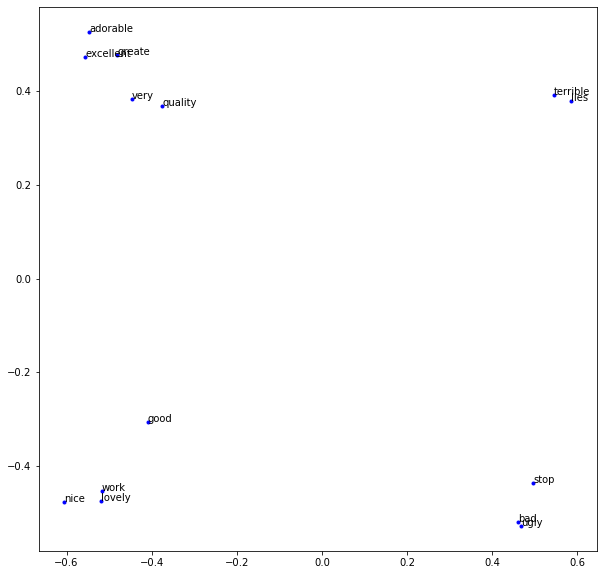

In [343]:
import matplotlib.pyplot as plt

embd_matrix = embd.get_weights()[0]
print(embd_matrix)
plt.figure(figsize=(10,10))  
for idx, (x1, x2) in enumerate(embd_matrix):
    if idx == 0 : continue
    plt.plot(x1, x2, 'b.')
    plt.annotate(t.index_word[idx], (x1,x2 ))

### Embeding Layer를 이용한 IMDB 텍스트 분류 실습
* IMDB 데이터 셋
    * imdb.com, 영화 리뷰 데이타셋
    * http://mng.bz/0tIo
* `tf.keras.datastes.imdb.load_data(num_words)`
    * `num_words` : 총 단어 갯수, 등장 빈도 순위 기준

#### 데이타 준비

In [1]:
import tensorflow as tf

imdb = tf.keras.datasets.imdb

voca_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=voca_size)
print(f'train set : {len(X_train)}, test set: {len(X_test), }, classes : {max(y_train)+1}')

train set : 25000, test set: (25000,), classes : 2


#### 단어-인덱스 사전 생성

In [2]:
imdb_word_index = imdb.get_word_index()
imdb_index_word = { idx : key for key, idx in imdb_word_index.items()}

print(imdb_index_word[1], imdb_word_index['the'])

the 1


#### 데이타 미리보기

In [9]:
print(X_train[0][:20])

# 0:pad, 1:<start>, 2:UNK 
' '.join([imdb_index_word.get(i-3, '?') for i in X_train[0][:20]])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you"

#### 패딩

In [10]:
#padding
max_len = 500
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

#### 모델 생성, 훈련, 평가

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(voca_size, 250))
model.add(tf.keras.layers.LSTM(120))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

result = model.evaluate(X_test, y_test)
print(f'cost :{result[0]}, accuracy:{result[1] * 100:.2f}%')

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 39s 2ms/sample - loss: 0.4619 - acc: 0.7776 - val_loss: 0.4323 - val_acc: 0.7946
Epoch 2/20
25000/25000 [==============================] - 38s 2ms/sample - loss: 0.2810 - acc: 0.8888 - val_loss: 0.3118 - val_acc: 0.8688
Epoch 3/20
25000/25000 [==============================] - 39s 2ms/sample - loss: 0.1878 - acc: 0.9290 - val_loss: 0.3479 - val_acc: 0.8660
Epoch 4/20
25000/25000 [==============================] - 39s 2ms/sample - loss: 0.1432 - acc: 0.9474 - val_loss: 0.4493 - val_acc: 0.8605
Epoch 5/20
25000/25000 [==============================] - 40s 2ms/sample - loss: 0.1142 - acc: 0.9581 - val_loss: 0.3961 - val_acc: 0.8683
Epoch 6/20
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.1072 - acc: 0.9613 - val_loss: 0.4287 - val_acc: 0.8546
Epoch 7/20
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.0674 - acc: 0.9771 - val_loss: 0.

### Word2Vec 원리
* 벡터에 단어간 유사도 반영
    * https://word2vec.kr/
    * 엄마-여자+남자=아빠
    * 2가지 방식
        * CBOW(Continuous Bag of Words)
        * Skip-gram 
* Skip-gram 모델
    * window size에 맞게 이웃하는 단어 선택
    * (context, target) 쌍 만들기
* 각 단어를 one-hot encoding으로 변환
* 예) king brave man/ queen beautiful women(window_size=1)
    * king[1,0,0,0,0,0] - brave[0,1,0,0,0,0]
    * brave[0,1,0,0,0,0] - man[0,0,1,0,0,0]
    * brave[0,1,0,0,0,0] - king[1,0,0,0,0,0]
    * queen[0,0,1,0,0,0] - beautiful[0,0,0,0,1,0]
    * beautiful[0,0,0,0,1,0] - women[0,0,0,0,0,1]
    * women[0,0,0,0,0,1] - beautiful[0,0,0,0,1,0]
*  hidden layer가 $n$인 네트워크에 input과 output으로 전달해서 학습
![](https://i.imgur.com/vjVYupm.png)
* 학습한 Weight를 입력 단어에 대한 벡터로 사용
* 예) Hidden-Layer : 2
    * king[1,1]
    * brave[1,2]
    * man[1,3]
    * queen[5,5]
    * beautiful[5,6]
    * women[5,7]

#### 학습 데이타 준비

In [18]:
import tensorflow as tf
import numpy as np

corpus = ['king is a brave man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results


corpus = remove_stop_words(corpus) # stop word 제거하기
print(corpus)

tknizer = tf.keras.preprocessing.text.Tokenizer()#stop_words)
tknizer.fit_on_texts(corpus)
display(tknizer.get_config())

['king brave man', 'queen wise woman', 'boy young man', 'girl young woman', 'prince young king', 'princess young queen', 'man strong', 'woman pretty', 'prince boy king', 'princess girl queen']


{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 10,
 'word_counts': '{"king": 3, "brave": 1, "man": 3, "queen": 3, "wise": 1, "woman": 3, "boy": 2, "young": 4, "girl": 2, "prince": 2, "princess": 2, "strong": 1, "pretty": 1}',
 'word_docs': '{"brave": 1, "man": 3, "king": 3, "queen": 3, "woman": 3, "wise": 1, "young": 4, "boy": 2, "girl": 2, "prince": 2, "princess": 2, "strong": 1, "pretty": 1}',
 'index_docs': '{"10": 1, "3": 3, "2": 3, "4": 3, "5": 3, "11": 1, "1": 4, "6": 2, "7": 2, "8": 2, "9": 2, "12": 1, "13": 1}',
 'index_word': '{"1": "young", "2": "king", "3": "man", "4": "queen", "5": "woman", "6": "boy", "7": "girl", "8": "prince", "9": "princess", "10": "brave", "11": "wise", "12": "strong", "13": "pretty"}',
 'word_index': '{"young": 1, "king": 2, "man": 3, "queen": 4, "woman": 5, "boy": 6, "girl": 7, "prince": 8, "princess": 9, "brave": 10, "wise": 11, "stro

#### Skip-gram 생성

In [20]:
WINDOW_SIZE =1

data = []
for sentence in corpus:
    sentence = sentence.split()
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
data[:5]

[['king', 'brave'],
 ['brave', 'king'],
 ['brave', 'man'],
 ['man', 'brave'],
 ['queen', 'wise']]

#### one-hot encoding

In [21]:
seq = np.array(tknizer.texts_to_sequences(data))
print(seq[:5])

x = seq[:, 0]
y = seq[:, 1]
x_enc = tf.keras.utils.to_categorical(x)
y_enc = tf.keras.utils.to_categorical(y)
print(x_enc[:5], y_enc[:5])

[[ 2 10]
 [10  2]
 [10  3]
 [ 3 10]
 [ 4 11]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


#### 모델 생성 및 학습

In [23]:
dim = max(tknizer.index_word) +1 
print(dim)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2, input_shape=(dim,)))
model.add(tf.keras.layers.Dense(dim, activation="softmax"))
model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(0.1),#'adam',
              optimizer=tf.keras.optimizers.SGD(0.05), #"sgd",
              metrics=['accuracy'])
model.fit(x_enc, y, epochs=5000, verbose=0)
model.evaluate(x_enc, y, verbose=1)


14
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 14)                42        
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
36/36 [==============================] - 0s 1ms/sample - loss: 1.3427 - accuracy: 0.3611


[1.342704349093967, 0.3611111]

#### 훈련된 weight로 벡터 만들기

In [24]:
w = model.layers[0].get_weights()[0]
b = model.layers[0].get_weights()[1]

vectors = w + b
vectors

array([[ 0.28805965, -0.06106028],
       [ 1.2514911 ,  0.0564786 ],
       [-1.1742154 , -3.4734473 ],
       [-3.4871283 , -2.606208  ],
       [-1.4287654 ,  1.3530334 ],
       [-2.8363633 ,  1.537886  ],
       [ 0.649869  , -0.77418613],
       [ 0.38207   ,  0.77047706],
       [-0.37656903, -2.2907145 ],
       [-0.5477647 ,  0.5419028 ],
       [ 2.502882  , -1.5092524 ],
       [ 2.1700172 ,  1.4670897 ],
       [ 4.179845  , -1.4738853 ],
       [ 1.3096627 ,  3.6312494 ]], dtype=float32)

#### $princess - woman - man$ 계산

In [25]:
princess = vectors[tknizer.word_index['princess']]
woman = vectors[tknizer.word_index['woman']]
man = vectors[tknizer.word_index['man']]
princess_woman_man = princess - woman + man
princess_woman_man

array([-1.1985297, -3.6021914], dtype=float32)

#### vector 시각화

Text(-1.1985297, -3.6021914, 'princess-woman+man')

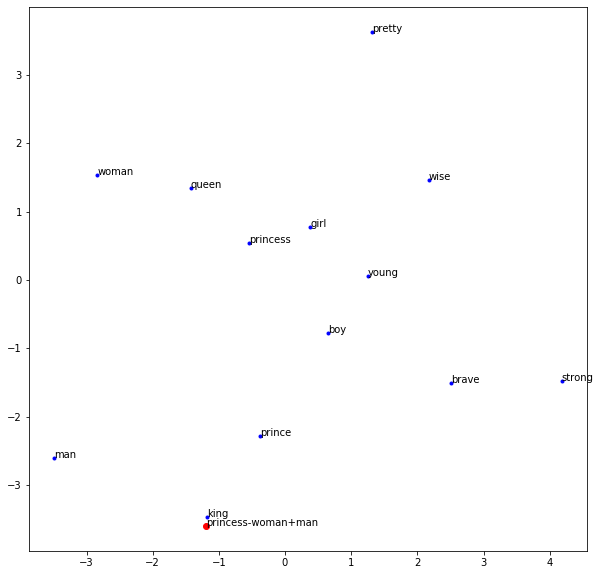

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))  
for idx, (x1, x2) in enumerate(vectors):
    if idx == 0: continue
    plt.plot(x1, x2, 'b.')
    word = tknizer.index_word[idx]
    plt.annotate(word, (x1,x2 ))
    
plt.plot(princess_woman_man[0],princess_woman_man[1], 'ro')
plt.annotate('princess-woman+man', princess_woman_man)

### 사전 훈련된 Word2Vec 임베딩 사용하기
* Word2Vec
    * Google Tomas Mikolov(토마스 미코로프)
    * gensim : Word2Vec 구현 라이브러리
        * https://radimrehurek.com/gensim/
        * `pip install gensim`
    * 사전 훈련된 가중치
        * https://code.google.com/archive/p/word2vec/
        * https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM
* GloVe
    * Stanford Univ. 2014
    * 사전 훈련된 가중치
        * http://nlp.stanford.edu/data/glove.6B.zip

#### 가중치 파일 다운로드

In [27]:
!wget https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM

'wget' is not recognized as an internal or external command,
operable program or batch file.


#### gensim 설치

In [ ]:
!pip install gensim

#### gensim에 가중치 파일 로딩

In [29]:
import gensim

w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  
print(w2v_model.vectors.shape)

(3000000, 300)


#### 'love' 단어의 벡터 값 보기

In [31]:
w2v_model['love'][:10]

array([ 0.10302734, -0.15234375,  0.02587891,  0.16503906, -0.16503906,
        0.06689453,  0.29296875, -0.26367188, -0.140625  ,  0.20117188],
      dtype=float32)

### 사전 훈련된 Word2Vec으로 IMDB 분류 실습

#### IMDB 데이타 준비

In [33]:
import tensorflow as tf

imdb = tf.keras.datasets.imdb

voca_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=voca_size-3) # 0,1,2 자리를 비우려고
print(f'train set : {len(X_train)}, test set: {len(X_test), }, classes : {max(y_train)+1}')

imdb_word_index = imdb.get_word_index()
imdb_index_word = { idx : key for key, idx in imdb_word_index.items()}

train set : 25000, test set: (25000,), classes : 2


#### 패딩

In [36]:
max_len = 500
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)
max(X_train.ravel())

9996

#### 데이타에 필요한 word2vec 벡터 가져오기
* imdb 데이타와 index 간에 3 차이 보간 필요

In [37]:
embedd_matrix = np.zeros((voca_size, 300))

for i in range(1, voca_size-3):
    word = imdb_index_word[i]
    if word in w2v_model:
        embedd_matrix[i+3] = w2v_model[word]

#### 'love' 단어로 벡터 확인

In [39]:
print(imdb_word_index['love'])
print(w2v_model['love'][:10])
print(embedd_matrix[116+3][:10])

116
[ 0.10302734 -0.15234375  0.02587891  0.16503906 -0.16503906  0.06689453
  0.29296875 -0.26367188 -0.140625    0.20117188]
[ 0.10302734 -0.15234375  0.02587891  0.16503906 -0.16503906  0.06689453
  0.29296875 -0.26367188 -0.140625    0.20117188]


#### 모델 생성, 훈련, 평가

In [41]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(voca_size, 300, weights=[embedd_matrix], trainable=False))
model.add(tf.keras.layers.LSTM(120))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

result = model.evaluate(X_test, y_test)
print(f'loss: {result[0]}, accurracy: {result[1]*100:.4f}%')

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.4906 - acc: 0.7660 - val_loss: 0.4184 - val_acc: 0.8182
Epoch 2/20
25000/25000 [==============================] - 29s 1ms/sample - loss: 0.4054 - acc: 0.8251 - val_loss: 0.3445 - val_acc: 0.8546
Epoch 3/20
25000/25000 [==============================] - 29s 1ms/sample - loss: 0.4521 - acc: 0.7892 - val_loss: 0.3643 - val_acc: 0.8413
Epoch 4/20
25000/25000 [==============================] - 29s 1ms/sample - loss: 0.4483 - acc: 0.7868 - val_loss: 0.4360 - val_acc: 0.7972
Epoch 5/20
25000/25000 [==============================] - 29s 1ms/sample - loss: 0.3539 - acc: 0.8474 - val_loss: 0.3213 - val_acc: 0.8615
Epoch 6/20
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.3052 - acc: 0.8742 - val_loss: 0.2822 - val_acc: 0.8836
Epoch 7/20
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.2763 - acc: 0.8870 - val_loss: 0.